In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.stats import norm
from matplotlib.patches import Rectangle

In [3]:
def import_demand_nodes(file_path):
    """
    Imports a CSV file containing demand nodes with columns for x coordinate, y coordinate, and demand value.
    
    Args:
        file_path (str): The path to the CSV file.
        
    Returns:
        pd.DataFrame: A dataframe containing the demand nodes data.
    """
    df = pd.read_csv(file_path)
    df.columns = ['xcoord', 'ycoord', 'demand']
    return df

def normalize_demand(df, grid_size = 1, demand_size = 1, normalize_grid = False, normalize_demand = False):
    """
    Normalizes the x and y coordinates of demand nodes to fit within a specified grid size
    and scales the demand values to a specified demand size.
    
    Args:
        df (pd.DataFrame): Dataframe containing demand nodes with 'xcoord', 'ycoord', and 'demand' columns.
        grid_size (float): The size of the grid to normalize coordinates to.
        demand_size (float): The size to scale demand values to.
        
    Returns:
        pd.DataFrame: A dataframe with normalized coordinates and scaled demand values.
    """

    if normalize_grid:
        max_x = df['xcoord'].max()
        max_y = df['ycoord'].max()
        
        df['xcoord'] = df['xcoord'] / max_x
        df['ycoord'] = df['ycoord'] / max_y

    if normalize_demand:
        total_demand = df['demand'].sum()
        df['demand'] = df['demand'] / total_demand

    df['xcoord'] = df['xcoord'] * grid_size
    df['ycoord'] = df['ycoord'] * grid_size
    df['demand'] = df['demand'] * demand_size
    return df

In [6]:
# Example usage
df = import_demand_nodes('input_demand.csv')
print(df)
df = normalize_demand(df, grid_size = 1, demand_size = 100, normalize_grid = True)
print(df)

   xcoord  ycoord  demand
0    0.00    0.05    0.05
1    0.03    0.04    0.06
2    0.60    0.70    0.12
3    0.80    0.90    0.15
4    0.50    0.40    0.10
5    0.04    0.70    0.08
6    0.90    0.10    0.20
     xcoord    ycoord  demand
0  0.000000  0.055556     5.0
1  0.033333  0.044444     6.0
2  0.666667  0.777778    12.0
3  0.888889  1.000000    15.0
4  0.555556  0.444444    10.0
5  0.044444  0.777778     8.0
6  1.000000  0.111111    20.0


In [16]:
def visualize_demand(df):
    """
    Visualize demand as edge-to-edge squares centered on each (x, y) node,
    colored by the 'demand' value. Cell size is inferred from coordinate spacing.

    Args:
        df (pd.DataFrame): Must have columns 'xcoord', 'ycoord', 'demand'.
    """
    x = np.asarray(df['xcoord'], dtype=float)
    y = np.asarray(df['ycoord'], dtype=float)
    w = np.asarray(df['demand'], dtype=float)

    # Infer cell size from spacing (fallback to 1.0 if spacing can't be inferred)
    def infer_step(vals):
        uniq = np.unique(vals)
        if uniq.size < 2:
            return 1.0
        diffs = np.diff(np.sort(uniq))
        return float(np.median(diffs[diffs > 0])) if np.any(diffs > 0) else 1.0

    step_x = infer_step(x)
    step_y = infer_step(y)
    cell = min(step_x, step_y)

    vmin, vmax = float(np.nanmin(w)), float(np.nanmax(w))
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.Blues

    # Figure & axes
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw one square per node (centered at (xi, yi))
    for xi, yi, wi in zip(x, y, w):
        rect = Rectangle(
            (xi - 0.5*cell, yi - 0.5*cell),
            cell, cell,
            facecolor=cmap(norm(wi)),
            edgecolor='none'   # change to 'k' and add linewidth=0.5 for grid lines
        )
        ax.add_patch(rect)

    # Axes limits with a small margin
    margin = 0.1 * cell
    ax.set_xlim(x.min() - 0.5*cell - margin, x.max() + 0.5*cell + margin)
    ax.set_ylim(y.min() - 0.5*cell - margin, y.max() + 0.5*cell + margin)

    # Labels & aspect
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title('Demand Nodes (Rectangular Tiles)')
    ax.grid(False)

    # Colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Demand')

    plt.show()

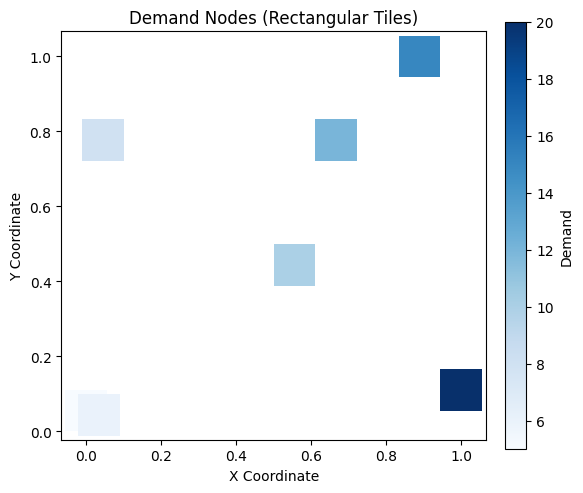

In [7]:
# Example usage
visualize_demand(df)

In [8]:
def create_cost_map(y_length, x_length, grain_size):
    """
    Creates a spatial map with specified dimensions and grain size.

    Args:
        y_length (float): The length of the map in the y-direction.
        x_length (float): The length of the map in the x-direction.
        grain_size (float): The size of each grid cell.

    Returns:
        pd.DataFrame: A dataframe containing x_coord, y_coord, and cost (all set to 1).
    """
    y_coords = np.arange(0, y_length, grain_size)
    x_coords = np.arange(0, x_length, grain_size)
    data = {'x_coord': [], 'y_coord': [], 'cost': []}

    for x in x_coords:
        for y in y_coords:
            data['x_coord'].append(x)
            data['y_coord'].append(y)
            data['cost'].append(1)

    return pd.DataFrame(data)

def visualize_cost_map(cost_map, grain_size):
    """
    Visualizes the cost map as edge-to-edge rectangular tiles (data-space sizing).
    Each grid cell is a rectangle of size grain_size x grain_size, colored by 'cost'.
    """
    grid = (
        cost_map
        .pivot(index='y_coord', columns='x_coord', values='cost')
        .sort_index(axis=0)   # y ascending
        .sort_index(axis=1)   # x ascending
    )
    
    # Compute cell edges from the coordinate axes
    x_vals = grid.columns.to_numpy(dtype=float)
    y_vals = grid.index.to_numpy(dtype=float)
    x_edges = np.concatenate([x_vals, [x_vals[-1] + grain_size]])
    y_edges = np.concatenate([y_vals, [y_vals[-1] + grain_size]])

    vmin = np.nanmin(grid.values)
    vmax = np.nanmax(grid.values)
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.Oranges

    plt.figure(figsize=(6, 6))
    mesh = plt.pcolormesh(
        x_edges, y_edges, grid.values,
        cmap=cmap, norm=norm, shading='flat', edgecolors='none'
    )

    plt.xlim(x_edges[0], x_edges[-1])
    plt.ylim(y_edges[0], y_edges[-1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Cost Map Visualization')

    cbar = plt.colorbar(mesh, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Cost Value')

    plt.grid(False)
    plt.show()

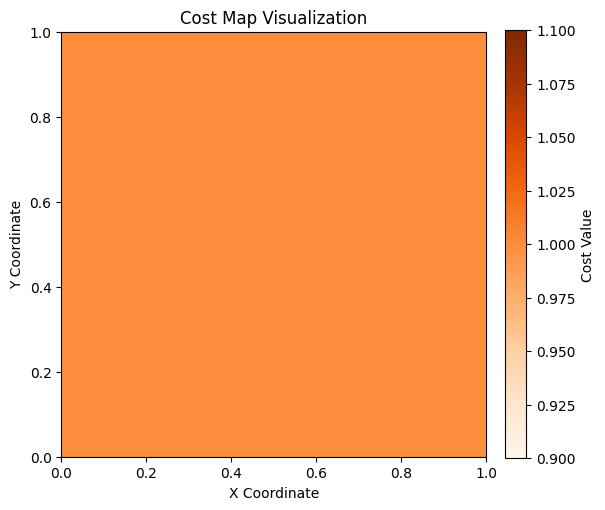

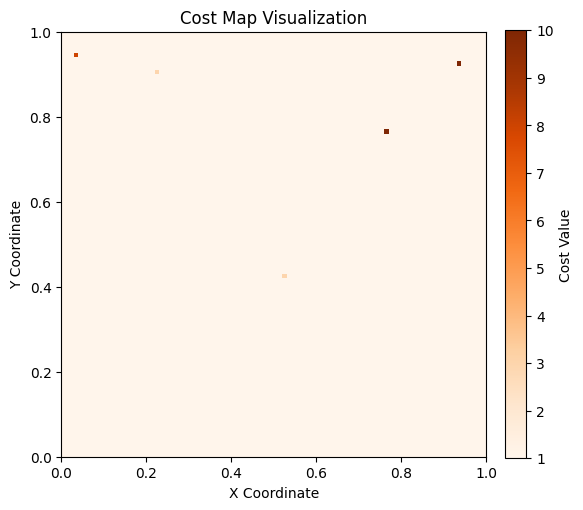

Size of spatial_map: 240128 bytes


In [9]:
# Example usage
cost_map = create_cost_map(y_length=1, x_length=1, grain_size=0.01)
visualize_cost_map(cost_map, grain_size=0.01)

random_indices = np.random.choice(cost_map.index, size=5, replace=False)
cost_map.loc[random_indices, 'cost'] = np.random.randint(2, 11, size=5)
visualize_cost_map(cost_map, grain_size=0.01)

spatial_map_size = cost_map.memory_usage(index=True).sum()
print(f"Size of spatial_map: {spatial_map_size} bytes")

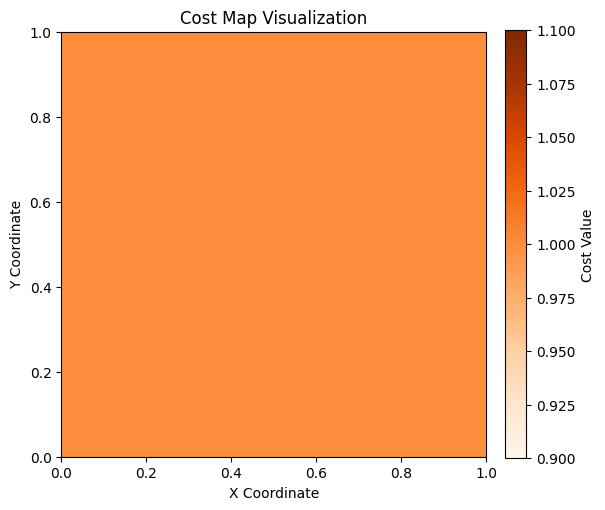

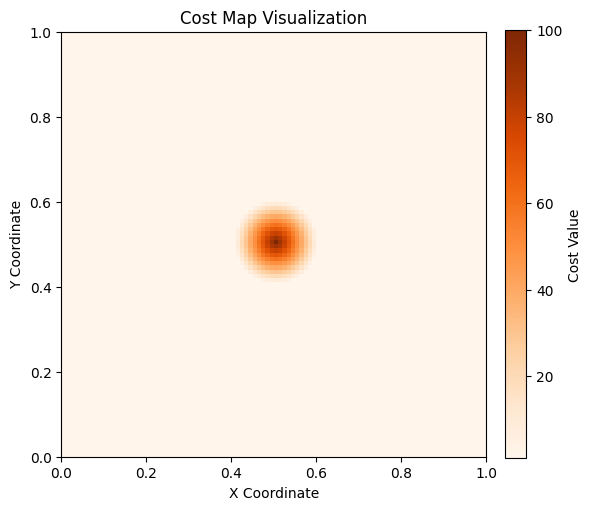

In [10]:
cost_map = create_cost_map(y_length=1, x_length=1, grain_size=0.01)
visualize_cost_map(cost_map, grain_size=0.01)

center_x, center_y = 0.5, 0.5
radius = 0.1
peak_cost = 100

# Visualize a "mountain"
cost_map['distance'] = np.sqrt((cost_map['x_coord'] - center_x)**2 + (cost_map['y_coord'] - center_y)**2)

cost_map['cost'] = cost_map['distance'].apply(
    lambda d: peak_cost if d == 0 else max(1,(peak_cost * (1 - d / radius))) if d <= radius else 1
)

cost_map.drop(columns=['distance'], inplace=True)
visualize_cost_map(cost_map, grain_size=0.01)

In [11]:
cost_map.to_csv('cost_map.csv', index=False)

In [12]:
def visualize_cost_and_demand(cost_df, demand_df, grain_size,
                              cost_cmap=plt.cm.Oranges,
                              demand_cmap=plt.cm.Blues,
                              demand_alpha=0.55,
                              draw_demand_edges=False,
                              demand_scale=1.0):
    """
    Render a cost raster (grid) and overlay demand tiles that are the same size as the grid cells.

    Parameters
    ----------
    cost_df : pd.DataFrame
        Columns: 'x_coord', 'y_coord', 'cost' (regular grid at spacing = grain_size)
    demand_df : pd.DataFrame
        Columns: 'xcoord', 'ycoord', 'demand' (ideally aligned to the same grid)
    grain_size : float
        Cell width/height in data units.
    cost_cmap : Colormap
        Colormap for cost.
    demand_cmap : Colormap
        Colormap for demand overlay.
    demand_alpha : float
        Alpha for demand rectangles (0 transparent … 1 opaque).
    draw_demand_edges : bool
        If True, draw edges around demand tiles.
    demand_scale : float
        Scale the demand tiles (1.0 = full cell, 0.8 = inset margins, etc.).
    """
    # --- Build cost grid for pcolormesh ---
    cost_grid = (
        cost_df
        .pivot(index='y_coord', columns='x_coord', values='cost')
        .sort_index(axis=0)    # y ascending
        .sort_index(axis=1)    # x ascending
    )
    x_vals = cost_grid.columns.to_numpy(dtype=float)
    y_vals = cost_grid.index.to_numpy(dtype=float)
    x_edges = np.concatenate([x_vals, [x_vals[-1] + grain_size]])
    y_edges = np.concatenate([y_vals, [y_vals[-1] + grain_size]])

    # --- Normalize/color for cost ---
    cost_vmin = float(np.nanmin(cost_grid.values))
    cost_vmax = float(np.nanmax(cost_grid.values))
    cost_norm = Normalize(vmin=cost_vmin, vmax=cost_vmax)

    fig, ax = plt.subplots(figsize=(7, 7))

    # COST: pcolormesh background (true raster cells)
    cost_mesh = ax.pcolormesh(
        x_edges, y_edges, cost_grid.values,
        cmap=cost_cmap, norm=cost_norm, shading='flat', edgecolors='none'
    )

    # --- Prepare DEMAND overlay ---
    # Map demand by coordinate for O(1) lookup
    demand_map = {(float(x), float(y)): float(w)
                  for x, y, w in zip(demand_df['xcoord'], demand_df['ycoord'], demand_df['demand'])}

    # Demand normalization (over present values)
    if len(demand_map) > 0:
        demand_vals = np.array(list(demand_map.values()), dtype=float)
        d_vmin = float(np.nanmin(demand_vals))
        d_vmax = float(np.nanmax(demand_vals))
        if d_vmin == d_vmax:  # avoid zero-range norm
            d_vmin -= 0.5
            d_vmax += 0.5
        demand_norm = Normalize(vmin=d_vmin, vmax=d_vmax)
    else:
        demand_norm = Normalize(vmin=0.0, vmax=1.0)

    # DEMAND: draw same-size tiles atop cost cells (optionally inset via demand_scale)
    half = 0.5 * grain_size * demand_scale
    ec = 'k' if draw_demand_edges else 'none'

    # Iterate over cost grid coordinates so alignment is guaranteed
    for x in x_vals:
        for y in y_vals:
            w = demand_map.get((float(x), float(y)))
            if w is None or np.isnan(w):
                continue  # no demand at this cell
            rgba = list(demand_cmap(demand_norm(w)))
            rgba[3] = demand_alpha  # set alpha
            rect = Rectangle(
                (x + 0.5*grain_size - half, y + 0.5*grain_size - half),
                2*half, 2*half,
                facecolor=tuple(rgba),
                edgecolor=ec,
                linewidth=0.6 if draw_demand_edges else 0.0
            )
            ax.add_patch(rect)

    # Axes & aspect
    ax.set_xlim(x_edges[0], x_edges[-1])
    ax.set_ylim(y_edges[0], y_edges[-1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Cost (raster) with Demand (aligned tiles)')

    # Colorbars: cost and demand
    cbar_cost = plt.colorbar(cost_mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar_cost.set_label('Cost')

    sm = ScalarMappable(cmap=demand_cmap, norm=demand_norm)
    sm.set_array([])
    cbar_dem = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.12)
    cbar_dem.set_label('Demand')

    plt.show()

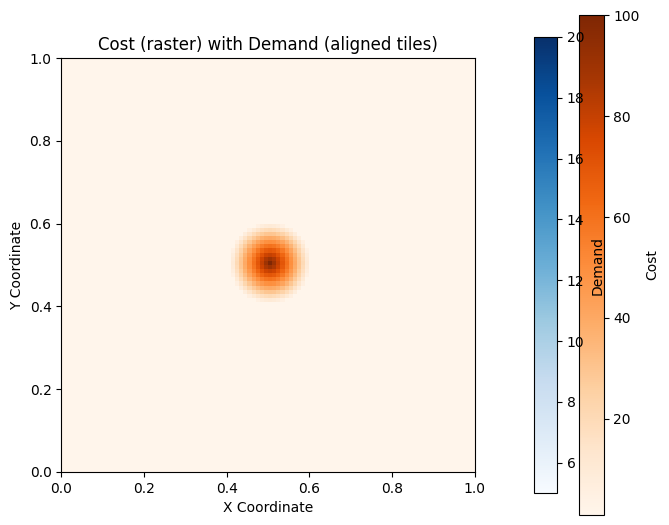

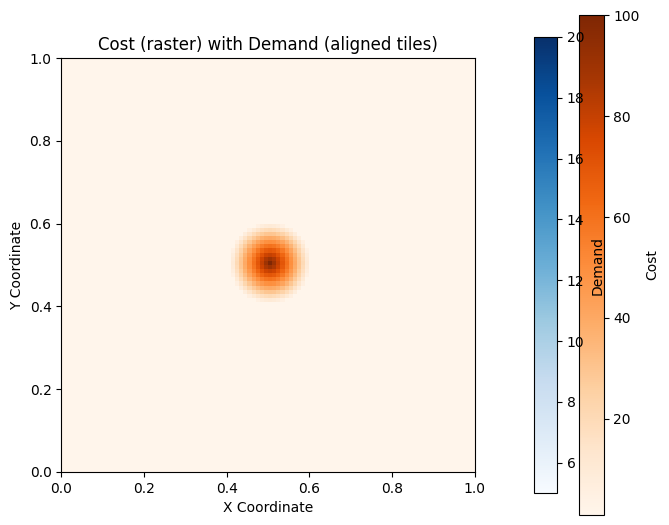

In [13]:
# cost_df from your create_cost_map(...), columns: x_coord, y_coord, cost
# demand_df with columns: xcoord, ycoord, demand (aligned to same grid)
visualize_cost_and_demand(cost_map, df, grain_size=0.01)

# make demand tiles slightly inset and outlined:
visualize_cost_and_demand(cost_map, df, grain_size=0.01,
                          demand_scale=0.8, draw_demand_edges=True)


In [21]:
def plot_cost_map_and_demand(cost_df,
                               demand_df,
                               grain_size,
                               cost_col='cost',
                               demand_col='demand',
                               ax=None,
                               cost_cmap=plt.cm.Oranges,
                               demand_cmap=plt.cm.Blues,
                               demand_alpha=0.55,
                               demand_scale=1.0,
                               draw_demand_edges=False,
                               snap_decimals=6):
    """Plot the cost raster and demand rectangles on the same axes."""
    if cost_df.empty:
        raise ValueError("cost_df is empty; nothing to plot.")
    if demand_df.empty:
        raise ValueError("demand_df is empty; nothing to plot.")

    cost_grid = (
        cost_df
        .pivot(index='y_coord', columns='x_coord', values=cost_col)
        .sort_index(axis=0)
        .sort_index(axis=1)
    )
    x_vals = cost_grid.columns.to_numpy(dtype=float)
    y_vals = cost_grid.index.to_numpy(dtype=float)
    x_edges = np.concatenate([x_vals, [x_vals[-1] + grain_size]])
    y_edges = np.concatenate([y_vals, [y_vals[-1] + grain_size]])

    cost_values = cost_grid.values
    cost_norm = Normalize(vmin=float(np.nanmin(cost_values)),
                          vmax=float(np.nanmax(cost_values)))

    created_ax = ax is None
    if created_ax:
        fig, ax = plt.subplots(figsize=(7, 7))
    else:
        fig = ax.figure

    cost_mesh = ax.pcolormesh(
        x_edges,
        y_edges,
        cost_values,
        cmap=cost_cmap,
        norm=cost_norm,
        shading='flat',
        edgecolors='none'
    )

    snapped = demand_df.copy()
    snapped['x_snap'] = np.round(snapped['xcoord'] / grain_size) * grain_size
    snapped['y_snap'] = np.round(snapped['ycoord'] / grain_size) * grain_size
    snapped['x_snap'] = snapped['x_snap'].round(snap_decimals)
    snapped['y_snap'] = snapped['y_snap'].round(snap_decimals)

    demand_map = {(float(x), float(y)): float(w)
                  for x, y, w in zip(snapped['x_snap'], snapped['y_snap'], snapped[demand_col])}

    if len(demand_map) > 0:
        demand_vals = np.array(list(demand_map.values()), dtype=float)
        d_vmin = float(np.nanmin(demand_vals))
        d_vmax = float(np.nanmax(demand_vals))
        if d_vmin == d_vmax:
            d_vmin -= 0.5
            d_vmax += 0.5
        demand_norm = Normalize(vmin=d_vmin, vmax=d_vmax)
    else:
        demand_norm = Normalize(vmin=0.0, vmax=1.0)

    half = 0.5 * grain_size * demand_scale
    ec = 'k' if draw_demand_edges else 'none'
    drawn_tiles = 0
    for x in x_vals:
        for y in y_vals:
            key = (float(np.round(x, snap_decimals)), float(np.round(y, snap_decimals)))
            w = demand_map.get(key)
            if w is None or np.isnan(w):
                continue
            rgba = list(demand_cmap(demand_norm(w)))
            rgba[3] = demand_alpha
            rect = Rectangle(
                (x + 0.5*grain_size - half, y + 0.5*grain_size - half),
                2*half, 2*half,
                facecolor=tuple(rgba),
                edgecolor=ec,
                linewidth=0.6 if draw_demand_edges else 0.0
            )
            ax.add_patch(rect)
            drawn_tiles += 1

    if drawn_tiles == 0:
        ax.text(0.5, 0.5, 'No snapped demand tiles overlap cost grid',
                transform=ax.transAxes, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    ax.set_xlim(x_edges[0], x_edges[-1])
    ax.set_ylim(y_edges[0], y_edges[-1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Cost map with demand rectangles')

    cbar_cost = fig.colorbar(cost_mesh, ax=ax, fraction=0.046, pad=0.04)
    cbar_cost.set_label('Cost')

    sm = ScalarMappable(cmap=demand_cmap, norm=demand_norm)
    sm.set_array([])
    cbar_demand = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.12)
    cbar_demand.set_label('Demand')

    if created_ax:
        plt.show()
    return ax


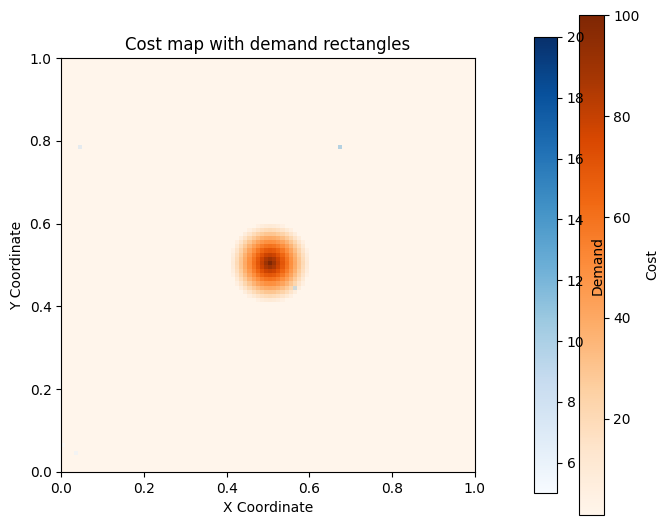

<Axes: title={'center': 'Cost map with demand rectangles'}, xlabel='X Coordinate', ylabel='Y Coordinate'>

In [22]:
plot_cost_map_and_demand(cost_map, df, grain_size=0.01)